In [1]:
#Expand notebook to take full screen width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

#Jupyter magic to notify when a cell finishes execution with %%notify command -- does not work with Jupyterlab
import jupyternotify
ip = get_ipython()
ip.register_magics(jupyternotify.JupyterNotifyMagics)

###
import sys
sys.path.insert(0,'../../src/')

%load_ext autoreload
%autoreload 2

%pdb

<IPython.core.display.Javascript object>

Automatic pdb calling has been turned ON


In [2]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets
from torch.nn.modules import Module
from torch.autograd import Variable
import torch.nn.functional as F
import numpy as np
import copy
import pickle
import model_archs

from utils_plot import show_sws_weights, show_weights, print_dims, prune_plot, draw_sws_graphs, joint_plot, plot_data, show_sws_weights_log
from utils_model import test_accuracy, train_epoch, retrain_sws_epoch, model_prune, get_weight_penalty, layer_accuracy
from utils_misc import trueAfterN, logsumexp, root_dir, model_load_dir, get_ab, get_sparsity
from utils_sws import GaussianMixturePrior, special_flatten, KL, compute_responsibilies, merger, sws_prune, sws_prune_l2, sws_prune_copy
from mnist_loader import search_train_data, search_retrain_data, search_validation_data, train_data, test_data, batch_size
from extract_targets import get_targets
from retrain_layer import init_retrain_layer
from retrain_model import retrain_model

test_data_full = Variable(test_data(fetch='data')).cuda()
test_labels_full = Variable(test_data(fetch='labels')).cuda()

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pickle

/anaconda/envs/py35/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/anaconda/envs/py35/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


### SWS

/anaconda/envs/py35/lib/python3.5/site-packages/torch/serialization.py:325: SourceChangeWarning: source code of class 'model_archs.LeNet_300_100' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


0-component Mean: 1000.0 Variance: 1000.0
Non-zero component Mean: 1.0 Variance: 0.1
Epoch: 10. Test Accuracy: 97.06, Prune Accuracy: 96.76, Sparsity: 97.61
Epoch: 20. Test Accuracy: 97.49, Prune Accuracy: 97.28, Sparsity: 97.62
Epoch: 30. Test Accuracy: 97.59, Prune Accuracy: 97.27, Sparsity: 97.64
Epoch: 40. Test Accuracy: 97.71, Prune Accuracy: 97.20, Sparsity: 97.67
Epoch: 50. Test Accuracy: 97.69, Prune Accuracy: 97.17, Sparsity: 97.73
Retrain Test: 97.69, Prune Test: 97.17, Prune Sparsity: 97.73


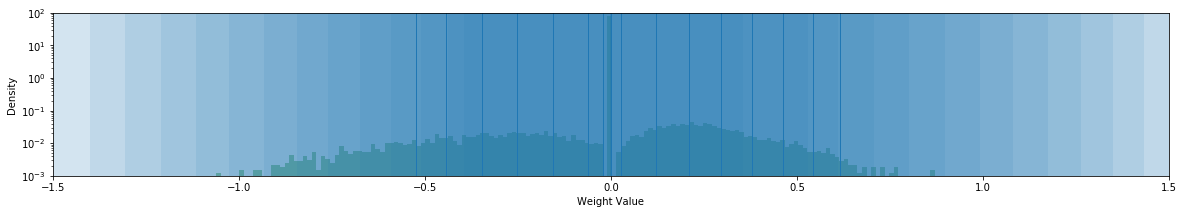

In [4]:
model, gmp, res = retrain_model(1, 0.1, 1000, 1000, 1e-6, int(0), 16, "LeNet_300_100", "full", 'CESNT', False, "")
show_sws_weights_log(model = model, means = list(gmp.means.data.clone().cpu()), precisions = list(gmp.gammas.data.clone().cpu()))

/anaconda/envs/py35/lib/python3.5/site-packages/torch/serialization.py:325: SourceChangeWarning: source code of class 'model_archs.LeNet_300_100' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


0-component Mean: 1000.0 Variance: 1000.0
Non-zero component Mean: 1.0 Variance: 0.1
Epoch: 10. Test Accuracy: 97.04, Prune Accuracy: 96.69, Sparsity: 97.63
Epoch: 20. Test Accuracy: 97.55, Prune Accuracy: 97.41, Sparsity: 97.65
Epoch: 30. Test Accuracy: 97.71, Prune Accuracy: 97.54, Sparsity: 97.66
Epoch: 40. Test Accuracy: 97.85, Prune Accuracy: 97.52, Sparsity: 97.71
Epoch: 50. Test Accuracy: 97.80, Prune Accuracy: 97.64, Sparsity: 97.73
Retrain Test: 97.80, Prune Test: 97.64, Prune Sparsity: 97.73


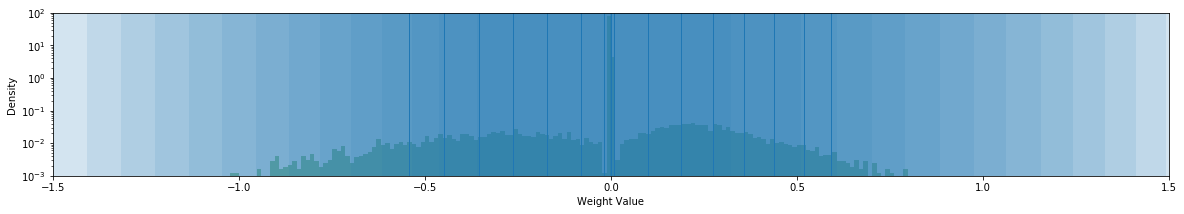

In [5]:
model, gmp, res = retrain_model(1, 0.1, 1000, 1000, 1e-6, int(0), 16, "LeNet_300_100", "full", 'CESNT', True, "")
show_sws_weights_log(model = model, means = list(gmp.means.data.clone().cpu()), precisions = list(gmp.gammas.data.clone().cpu()))

/anaconda/envs/py35/lib/python3.5/site-packages/torch/serialization.py:325: SourceChangeWarning: source code of class 'model_archs.LeNet_300_100' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


0-component Mean: 1000.0 Variance: 1000.0
Non-zero component Mean: 1.0 Variance: 0.1
Scaling Disabled - Epoch 0
Epoch: 10. Test Accuracy: 97.13, Prune Accuracy: 96.47, Sparsity: 97.63
Epoch: 20. Test Accuracy: 97.70, Prune Accuracy: 97.29, Sparsity: 97.65
Epoch: 30. Test Accuracy: 97.68, Prune Accuracy: 97.50, Sparsity: 97.63
Epoch: 40. Test Accuracy: 97.82, Prune Accuracy: 97.58, Sparsity: 97.68
Epoch: 50. Test Accuracy: 97.69, Prune Accuracy: 97.52, Sparsity: 97.71
Retrain Test: 97.69, Prune Test: 97.52, Prune Sparsity: 97.71


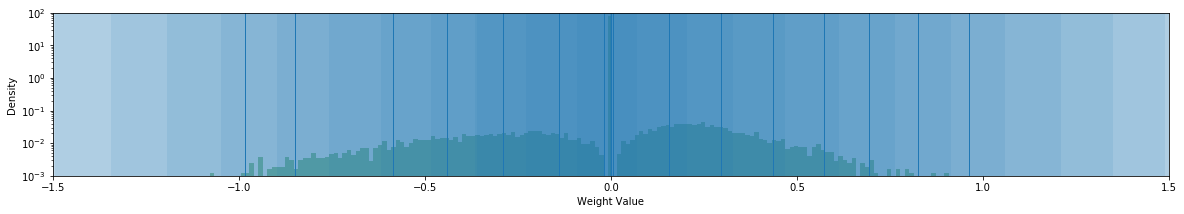

In [8]:
model, gmp, res = retrain_model(1, 0.1, 1000, 1000, 1e-6, int(0), 16, "LeNet_300_100", "full", 'CESNT', True, "./files", fn = "_S0")
show_sws_weights_log(model = model, means = list(gmp.means.data.clone().cpu()), precisions = list(gmp.gammas.data.clone().cpu()))

### SWS + KD

#### CE

/anaconda/envs/py35/lib/python3.5/site-packages/torch/serialization.py:325: SourceChangeWarning: source code of class 'model_archs.LeNet_300_100' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


0-component Mean: 5000.0 Variance: 1000.0
Non-zero component Mean: 1000.0 Variance: 0.1
Epoch: 10. Test Accuracy: 98.34, Prune Accuracy: 98.13, Sparsity: 65.04
Epoch: 20. Test Accuracy: 98.12, Prune Accuracy: 96.18, Sparsity: 89.24
Epoch: 30. Test Accuracy: 98.11, Prune Accuracy: 96.78, Sparsity: 96.95
Epoch: 40. Test Accuracy: 98.10, Prune Accuracy: 97.31, Sparsity: 96.95
Epoch: 50. Test Accuracy: 98.12, Prune Accuracy: 97.61, Sparsity: 96.96
Retrain Test: 98.12, Prune Test: 97.61, Prune Sparsity: 96.96


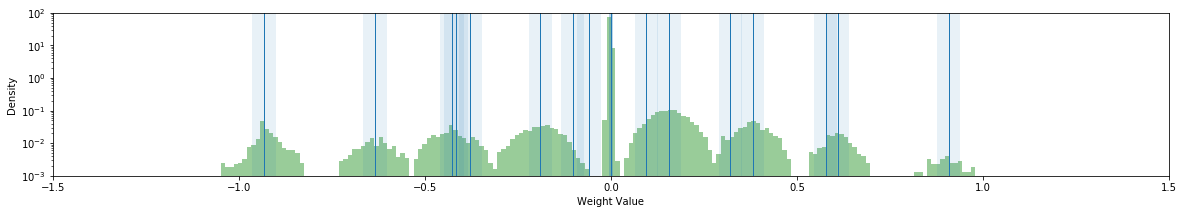

In [6]:
model, gmp, res = retrain_model(1000, 0.1, 5000, 1000, 1e-5, 5, 16, "LeNet_300_100", "full", 'CEST', False, "", fn = "_CE")
show_sws_weights_log(model = model, means = list(gmp.means.data.clone().cpu()), precisions = list(gmp.gammas.data.clone().cpu()))

/anaconda/envs/py35/lib/python3.5/site-packages/torch/serialization.py:325: SourceChangeWarning: source code of class 'model_archs.LeNet_300_100' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


0-component Mean: 5000.0 Variance: 1000.0
Non-zero component Mean: 1000.0 Variance: 0.1
Epoch: 10. Test Accuracy: 98.31, Prune Accuracy: 97.56, Sparsity: 73.42
Epoch: 20. Test Accuracy: 97.71, Prune Accuracy: 94.17, Sparsity: 97.50
Epoch: 30. Test Accuracy: 97.83, Prune Accuracy: 96.21, Sparsity: 97.50
Epoch: 40. Test Accuracy: 97.73, Prune Accuracy: 96.56, Sparsity: 97.50
Epoch: 50. Test Accuracy: 97.69, Prune Accuracy: 96.87, Sparsity: 97.50
Retrain Test: 97.69, Prune Test: 96.87, Prune Sparsity: 97.50


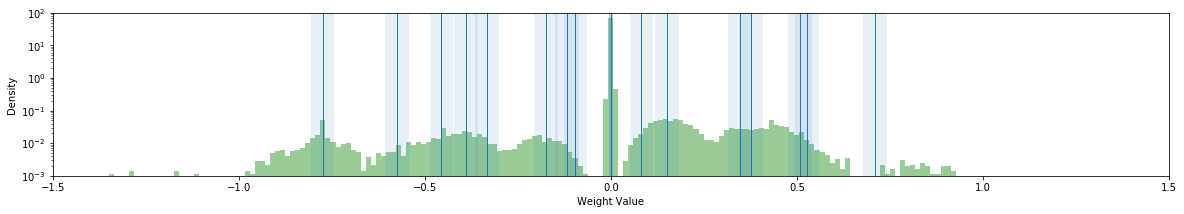

In [7]:
#tau -> 1.5
model, gmp, res = retrain_model(1000, 0.1, 5000, 1000, 1.5e-5, 5, 16, "LeNet_300_100", "full", 'CEST', True, "", fn = "_CE")
show_sws_weights_log(model = model, means = list(gmp.means.data.clone().cpu()), precisions = list(gmp.gammas.data.clone().cpu()))

/anaconda/envs/py35/lib/python3.5/site-packages/torch/serialization.py:325: SourceChangeWarning: source code of class 'model_archs.LeNet_300_100' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


0-component Mean: 5000.0 Variance: 1000.0
Non-zero component Mean: 1000.0 Variance: 0.1
Scaling Disabled - Epoch 0
Epoch: 10. Test Accuracy: 98.37, Prune Accuracy: 97.60, Sparsity: 70.51
Epoch: 20. Test Accuracy: 98.02, Prune Accuracy: 94.94, Sparsity: 88.62
Epoch: 30. Test Accuracy: 98.00, Prune Accuracy: 96.00, Sparsity: 97.10
Epoch: 40. Test Accuracy: 98.14, Prune Accuracy: 96.46, Sparsity: 97.13
Epoch: 50. Test Accuracy: 98.14, Prune Accuracy: 96.53, Sparsity: 97.13
Retrain Test: 98.14, Prune Test: 96.53, Prune Sparsity: 97.13


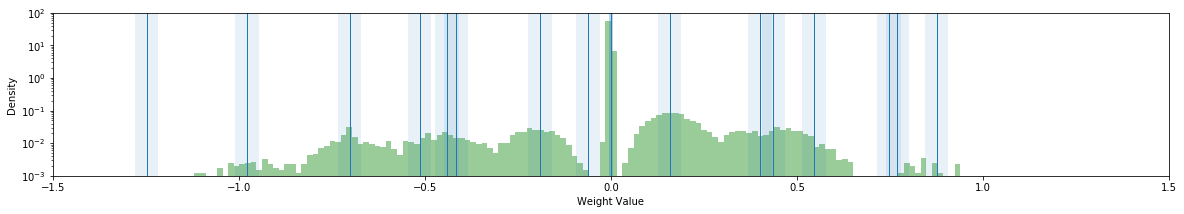

In [9]:
#tau -> 1.5, LR -> 0
model, gmp, res = retrain_model(1000, 0.1, 5000, 1000, 1e-5, 5, 16, "LeNet_300_100", "full", 'CEST', True, "./files", fn = "_CE_S0")
show_sws_weights_log(model = model, means = list(gmp.means.data.clone().cpu()), precisions = list(gmp.gammas.data.clone().cpu()))

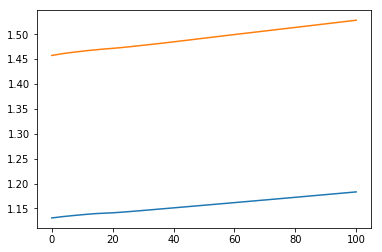

In [37]:
plt.plot(res['scale'])

#### MSE

/anaconda/envs/py35/lib/python3.5/site-packages/torch/serialization.py:325: SourceChangeWarning: source code of class 'model_archs.LeNet_300_100' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


0-component Mean: 2500.0 Variance: 1250.0
Non-zero component Mean: 250.0 Variance: 10.0
Epoch: 10. Test Accuracy: 98.27, Prune Accuracy: 97.80, Sparsity: 68.91
Epoch: 20. Test Accuracy: 97.78, Prune Accuracy: 97.25, Sparsity: 96.58
Epoch: 30. Test Accuracy: 98.00, Prune Accuracy: 97.51, Sparsity: 96.62
Epoch: 40. Test Accuracy: 98.01, Prune Accuracy: 97.64, Sparsity: 96.66
Epoch: 50. Test Accuracy: 98.14, Prune Accuracy: 97.81, Sparsity: 96.69
Retrain Test: 98.14, Prune Test: 97.81, Prune Sparsity: 96.69


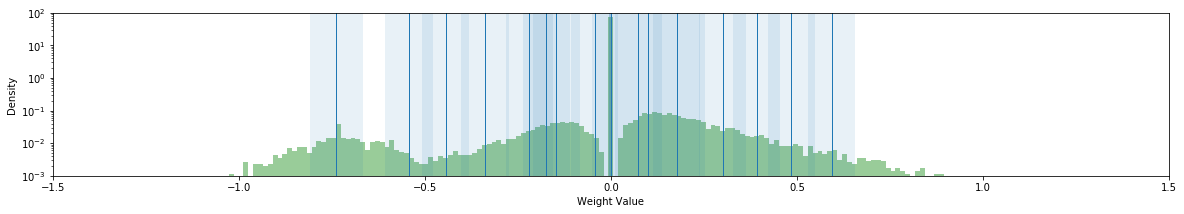

In [8]:
model, gmp, res = retrain_model(250, 10, 2500, 1250, 1e-6, 5, 16, "LeNet_300_100", "full", 'MSEST', False, "", fn = "_MSE")
show_sws_weights_log(model = model, means = list(gmp.means.data.clone().cpu()), precisions = list(gmp.gammas.data.clone().cpu()))

/anaconda/envs/py35/lib/python3.5/site-packages/torch/serialization.py:325: SourceChangeWarning: source code of class 'model_archs.LeNet_300_100' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


0-component Mean: 2500.0 Variance: 1250.0
Non-zero component Mean: 250.0 Variance: 10.0
Epoch: 10. Test Accuracy: 98.03, Prune Accuracy: 97.38, Sparsity: 82.34
Epoch: 20. Test Accuracy: 97.61, Prune Accuracy: 97.14, Sparsity: 97.17
Epoch: 30. Test Accuracy: 97.85, Prune Accuracy: 97.31, Sparsity: 97.20
Epoch: 40. Test Accuracy: 97.93, Prune Accuracy: 97.42, Sparsity: 97.23
Epoch: 50. Test Accuracy: 98.00, Prune Accuracy: 97.47, Sparsity: 97.26
Retrain Test: 98.00, Prune Test: 97.47, Prune Sparsity: 97.26


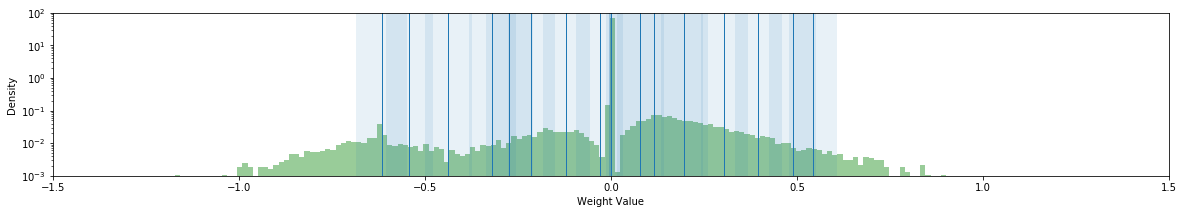

In [9]:
model, gmp, res = retrain_model(250, 10, 2500, 1250, 1.3e-6, 5, 16, "LeNet_300_100", "full", 'MSEST', True, "", fn = "_MSE")
show_sws_weights_log(model = model, means = list(gmp.means.data.clone().cpu()), precisions = list(gmp.gammas.data.clone().cpu()))

/anaconda/envs/py35/lib/python3.5/site-packages/torch/serialization.py:325: SourceChangeWarning: source code of class 'model_archs.LeNet_300_100' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


0-component Mean: 2500.0 Variance: 1250.0
Non-zero component Mean: 250.0 Variance: 10.0
Epoch: 10. Test Accuracy: 98.11, Prune Accuracy: 84.19, Sparsity: 83.47
Epoch: 20. Test Accuracy: 97.55, Prune Accuracy: 96.89, Sparsity: 97.46
Epoch: 30. Test Accuracy: 97.93, Prune Accuracy: 97.39, Sparsity: 88.45
Epoch: 40. Test Accuracy: 97.89, Prune Accuracy: 97.57, Sparsity: 97.32
Epoch: 50. Test Accuracy: 97.93, Prune Accuracy: 97.75, Sparsity: 97.32
Retrain Test: 97.93, Prune Test: 97.75, Prune Sparsity: 97.32


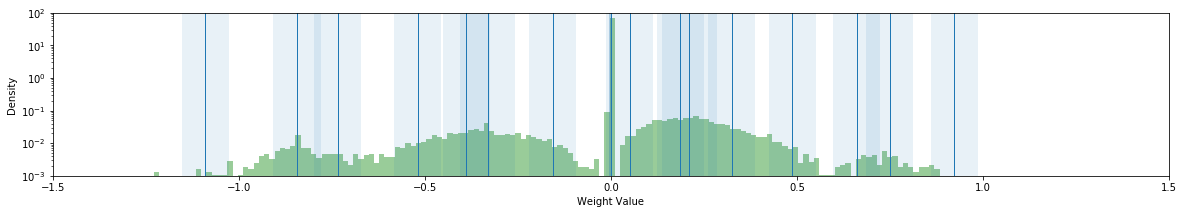

In [6]:
#LR -> 0
model, gmp, res = retrain_model(250, 10, 2500, 1250, 1.3e-6, 5, 16, "LeNet_300_100", "full", 'MSEST', True, "./files", fn = "_MSE_S0")
show_sws_weights_log(model = model, means = list(gmp.means.data.clone().cpu()), precisions = list(gmp.gammas.data.clone().cpu()))